In [84]:
# Run this cell to ensure that altair plots show up without having
# the notebook be really large.
# We will talk more about what these lines do later in the course

import os
import altair as alt
import pandas as pd
import json
from toolz.curried import pipe

# Create a new data transformer that stores the files in a directory
def json_dir(data, data_dir='altairdata'):
    os.makedirs(data_dir, exist_ok=True)
    return pipe(data, alt.to_json(filename=data_dir + '/{prefix}-{hash}.{extension}') )

# Register and enable the new transformer
alt.data_transformers.register('json_dir', json_dir)
alt.data_transformers.enable('json_dir')

# Handle large data sets (default shows only 5000)
# See here: https://altair-viz.github.io/user_guide/data_transformers.html
alt.data_transformers.disable_max_rows()

alt.renderers.enable('jupyterlab')

RendererRegistry.enable('jupyterlab')

In [100]:
path = '../../data/processed/cleaned_games.csv'
data = pd.read_csv(path)
data = data.loc[(data['release_date'] >= '2023-01-05') & (data['release_date'] <= '2025-01-08')]
print(data.shape)
data.head()

(17825, 21)


,Unnamed: 0,steam_appid,name,developers,publishers,categories,genres,required_age,n_achievements,platforms,...,additional_content,total_reviews,total_positive,total_negative,review_score,review_score_desc,positive_percentual,metacritic,is_free,price_initial (USD)
0,0,2719580,勇者の伝説の勇者,['ぽけそう'],['ぽけそう'],"['Single-player', 'Family Sharing']","['Casual', 'Indie']",0,0,['windows'],...,[],0,0,0,0.0,No user reviews,0.0,0,False,0.99
1,2,2719600,Lorhaven: Cursed War,['GoldenGod Games'],['GoldenGod Games'],"['Single-player', 'Multi-player', 'PvP', 'Shar...","['RPG', 'Strategy']",0,32,"['windows', 'mac']",...,[],9,8,1,0.0,9 user reviews,88.9,0,False,9.99
2,3,2719610,PUIQ: Demons,['Giammnn'],['Giammnn'],"['Single-player', 'Steam Achievements', 'Famil...","['Action', 'Casual', 'Indie', 'RPG']",0,28,['windows'],...,[],0,0,0,0.0,No user reviews,0.0,0,False,2.99
3,4,2719650,Project XSTING,['Saucy Melon'],['Saucy Melon'],"['Single-player', 'Steam Achievements', 'Steam...","['Action', 'Casual', 'Indie', 'Early Access']",0,42,['windows'],...,[],9,9,0,0.0,9 user reviews,100.0,0,False,7.99
4,7,2719710,Manor Madness,['Apericot Studio'],['Apericot Studio'],"['Single-player', 'Steam Achievements', 'HDR a...","['Action', 'Adventure', 'Indie', 'RPG', 'Simul...",0,5,"['windows', 'mac', 'linux']",...,[],0,0,0,0.0,No user reviews,0.0,0,True,0.00


In [101]:
columns_to_process = ['developers', 'publishers', 'categories', 'genres', 'platforms']
for col in columns_to_process:
    data[col] = data[col].apply(lambda x: eval(x) if isinstance(x, str) else x)

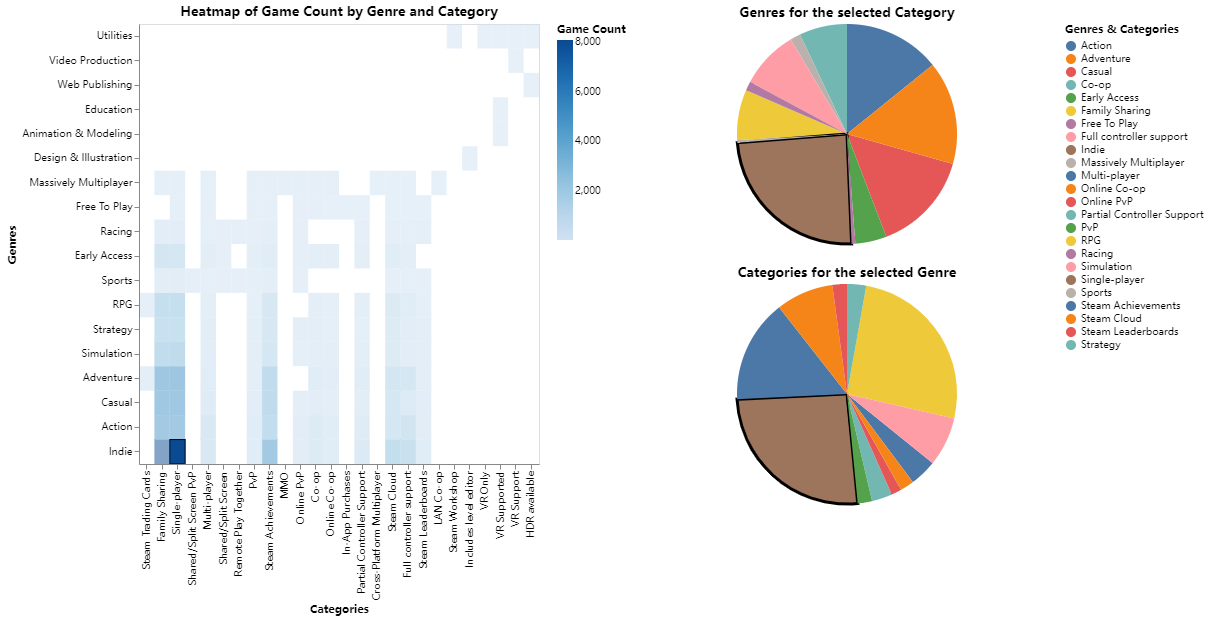

In [138]:
explode_data = data.explode('categories').explode('genres')
explode_data = explode_data[explode_data['categories'].notna()]
explode_data = explode_data[explode_data['categories'] != 'null']
explode_data = explode_data[explode_data['genres'].notna()]
explode_data = explode_data[explode_data['genres'] != 'null']
explode_data = explode_data[explode_data['total_reviews'] != 0]

category_selection = alt.selection_point(
    fields=['categories'], 
    value=[{'categories': 'Single-player'}],
    nearest=True
)

genre_selection = alt.selection_point(
    fields=['genres'], 
    value=[{'genres': 'Indie'}],
    nearest=True
)

all_checkbox = alt.binding_checkbox(name="Show All Categories and Genres: ")
checkbox_selection = alt.param(bind=all_checkbox, value=False)
slider_cate = alt.binding_range(min=5, max=20, step=1, name="Top Categories: ")
top_view_selection_cate = alt.param(name="top_view_cate", bind=slider_cate, value=12)
slider_genre = alt.binding_range(min=5, max=20, step=1, name="Top Genres: ")
top_view_selection_genre = alt.param(name="top_view_genre", bind=slider_genre, value=12)

heatmap = alt.Chart(explode_data).transform_aggregate(
    count_games='distinct(steam_appid)',
    groupby=['genres', 'categories']
).transform_window(
    genre_rank='rank()',
    sort=[alt.SortField('count_games', order='descending')],
    groupby=['genres'] 
).transform_window(
    category_rank='rank()',
    sort=[alt.SortField('count_games', order='descending')],
    groupby=['categories']
).transform_filter(
    alt.expr.if_(checkbox_selection, True, alt.datum.genre_rank <= top_view_selection_genre)
).transform_filter(
    alt.expr.if_(checkbox_selection, True, alt.datum.category_rank <= top_view_selection_cate)
).mark_rect().encode(
    x=alt.X('categories:N', title="Categories", sort=alt.SortField('count_games', order='descending')),
    y=alt.Y('genres:N', title="Genres", sort=alt.SortField('count_games', order='ascending')),
    color=alt.Color('count_games:Q', scale=alt.Scale(scheme='blues'), title="Game Count"),
    stroke=alt.condition(category_selection & genre_selection, alt.value('black'), alt.value(None)),
    opacity=alt.condition(category_selection & genre_selection, alt.value(1), alt.value(0.5)),
    tooltip=[
        alt.Tooltip('categories:N', title="Category"),
        alt.Tooltip('genres:N', title="Genre"),
        alt.Tooltip('count_games:Q', title="Total Games")
    ]
).properties(
    title="Heatmap of Game Count by Genre and Category",
    width=400,
    height=440
).add_params(checkbox_selection, top_view_selection_cate, top_view_selection_genre, category_selection, genre_selection)


cate_pi_chart = alt.Chart(explode_data).transform_filter(
    category_selection
).transform_aggregate(
    genre_count="count()",
    groupby=["genres"]
).transform_window(
    rank="rank()",
    sort=[alt.SortField("genre_count", order="descending")]
).transform_filter(
    alt.expr.if_(checkbox_selection, True, alt.datum.rank <= top_view_selection_cate)
).mark_arc().encode(
    theta=alt.Theta("genre_count:Q"),
    color=alt.Color("genres:N", legend=alt.Legend(title="Genres & Categories")),
    stroke=alt.condition(genre_selection, alt.value('black'), alt.value(None)),
    strokeWidth=alt.condition(genre_selection, alt.value(3), alt.value(0.5)),
    tooltip=[alt.Tooltip("genres:N", title="Genre"),
             alt.Tooltip("genre_count:Q", title="Total Count")]
).properties(
    title=alt.TitleParams(
        "Genres for the selected Category",
        anchor="middle",
    ),
    height=220,
    width=400
).add_params(checkbox_selection, top_view_selection_cate)


genre_pi_chart = alt.Chart(explode_data).transform_filter(
    genre_selection
).mark_arc().transform_aggregate(
    category_count="count()",
    groupby=["categories"]
).transform_window(
    rank="rank()", 
    sort=[alt.SortField("category_count", order="descending")]
).transform_filter(
    alt.expr.if_(checkbox_selection, True, alt.datum.rank <= top_view_selection_genre)
).encode(
    theta=alt.Theta("category_count:Q"),
    color=alt.Color("categories:N", legend=alt.Legend(title="Genres & Categories")),
    stroke=alt.condition(category_selection, alt.value('black'), alt.value(None)),
    strokeWidth=alt.condition(category_selection, alt.value(3), alt.value(0.5)),
    tooltip=[alt.Tooltip("categories:N", title="Category"),
             alt.Tooltip("category_count:Q", title="Total Count")]
).properties(
    title=alt.TitleParams(
        "Categories for the selected Genre", 
        anchor="middle",
    ),
    height=220,
    width=400,
).add_params(checkbox_selection, top_view_selection_genre)

combin_pi_charts = alt.vconcat(cate_pi_chart, genre_pi_chart)
view_1 = alt.hconcat(heatmap, combin_pi_charts)
view_1

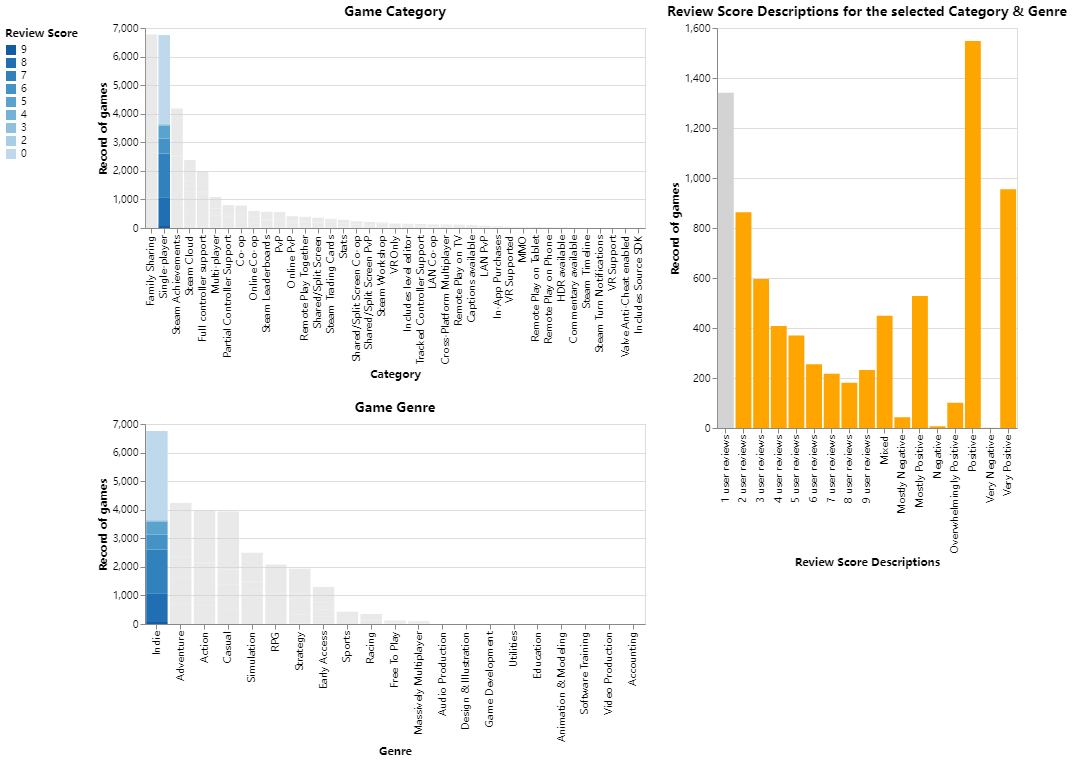

In [186]:
category_selection = alt.selection_point(fields=['categories'], value=[{'categories': 'Single-player'}])  
genre_selection = alt.selection_point(fields=['genres'], value=[{'genres': 'Indie'}])
# decs_selection = alt.selection_point(fields=['review_score_desc'], encodings=['x'], value=explode_data['review_score_desc'].unique().tolist(), toggle=True)
decs_selection = alt.selection_point(
    fields=['review_score_desc'], 
    encodings=['x'],
    toggle=True,
    value=[{'review_score_desc': '1 user reviews'}]
)
# all_checkbox = alt.binding_checkbox(name="Show All Categories and Genres: ")
# checkbox_selection = alt.param(bind=all_checkbox, value=False)
# slider_cate = alt.binding_range(min=5, max=20, step=1, name="Top Categories: ")
# top_view_selection_cate = alt.param(name="top_view_cate", bind=slider_cate, value=12)
# slider_genre = alt.binding_range(min=5, max=20, step=1, name="Top Genres: ")
# top_view_selection_genre = alt.param(name="top_view_genre", bind=slider_genre, value=12)

hist_cate = alt.Chart(explode_data).transform_filter(
    genre_selection
).transform_filter(
    ~decs_selection
).transform_window(
    rank="rank()",
    sort=[alt.SortField("count()", order="descending")],
    groupby=["categories"]
).mark_bar().encode(
    x=alt.X('categories:N', title="Category", sort='-y'),
    y=alt.Y('count():Q', title="Record of games"),
    color=alt.condition(
        category_selection,  
        alt.Color('review_score:O', legend=alt.Legend(title="Review Score", orient="left"), scale=alt.Scale(scheme="blues", reverse=True), sort='descending'),
        alt.value('lightgray')
    ),
    opacity=alt.condition(category_selection, alt.value(1), alt.value(0.5)),
    tooltip=[
        alt.Tooltip('categories:N', title="Category"),
        alt.Tooltip('review_score:O', title="Review Score"),
        alt.Tooltip('count():Q', title="Number of Games")
    ]
).properties(
    title='Game Category',
    width=500,
    height=200
).add_params(category_selection)

hist_genre = alt.Chart(explode_data).transform_filter(
    category_selection
).transform_filter(
    ~decs_selection
).transform_window(
    rank="rank()",
    sort=[alt.SortField("count()", order="descending")],
    groupby=["genres"]
).mark_bar().encode(
    x=alt.X('genres:N', title="Genre", sort='-y'),
    y=alt.Y('count():Q', title="Record of games"),
    color=alt.condition(
        genre_selection,  
        alt.Color('review_score:O', legend=alt.Legend(title="Review Score", orient="left"), scale=alt.Scale(scheme="blues", reverse=True),sort='descending'),
        alt.value('lightgray')
    ),
    opacity=alt.condition(genre_selection, alt.value(1), alt.value(0.5)),
    tooltip=[
        alt.Tooltip('genres:N', title="Genre"),
        alt.Tooltip('review_score:O', title="Review Score"),
        alt.Tooltip('count():Q', title="Number of Games")
    ]
).properties(
    title='Game Genre',
    width=500,
    height=200
).add_params(genre_selection)

hist_review_desc = alt.Chart(explode_data).transform_filter(
    category_selection
).transform_filter(
    genre_selection
).mark_bar().encode(
    x=alt.X('review_score_desc:N', title="Review Score Descriptions"),
    y=alt.Y('count():Q', title="Record of games"),
    color=alt.condition(decs_selection, alt.value('lightgray'), alt.value('orange')),
    tooltip=[
        alt.Tooltip('genres:N', title="Genre"),
        alt.Tooltip('categories:N', title="Category"),
        alt.Tooltip('review_score_desc:N', title="Review Score Descriptions"),
        alt.Tooltip('count():Q', title="Number of Games")
    ]
).properties(
    title='Review Score Descriptions for the selected Category & Genre',
    width=300,
    height=400
).add_params(decs_selection)

selection_hists = alt.vconcat(hist_cate, hist_genre).resolve_scale(color="shared")
view_2 = alt.hconcat(selection_hists, hist_review_desc)
view_2

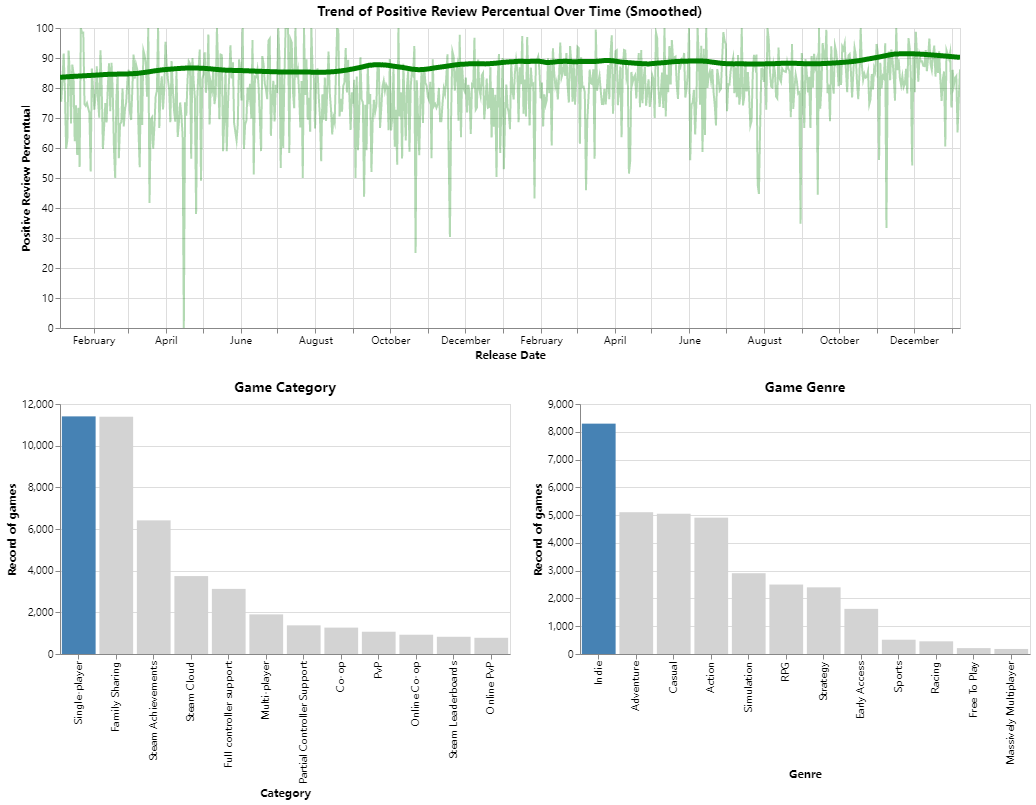

In [190]:
category_selection = alt.selection_point(fields=['categories'], value=[{'categories': 'Single-player'}])  
genre_selection = alt.selection_point(fields=['genres'], value=[{'genres': 'Indie'}])

all_checkbox = alt.binding_checkbox(name="Show All Categories and Genres: ")
checkbox_selection = alt.param(bind=all_checkbox, value=False)
slider_cate = alt.binding_range(min=5, max=20, step=1, name="Top Categories: ")
top_view_selection_cate = alt.param(name="top_view_cate", bind=slider_cate, value=12)
slider_genre = alt.binding_range(min=5, max=20, step=1, name="Top Genres: ")
top_view_selection_genre = alt.param(name="top_view_genre", bind=slider_genre, value=12)
x_range_selection = alt.selection_interval(
    encodings=['x'],
    bind='scales'
)

hist_cate = alt.Chart(explode_data).transform_filter(
    x_range_selection
).transform_aggregate(
    unique_games="distinct(steam_appid)",
    groupby=["categories"]
).transform_window(
    rank="rank()", 
    sort=[alt.SortField("unique_games", order="descending")]
).transform_filter(
    alt.expr.if_(checkbox_selection, True, alt.datum.rank <= top_view_selection_cate)
).mark_bar().encode(
    x=alt.X('categories:N', title="Category", sort='-y'),
    y=alt.Y('unique_games:Q', title="Record of games"),
    color=alt.condition(category_selection, alt.value('steelblue'), alt.value('lightgray')),
).properties(
    title='Game Category',
    width=450,
    height=250
).add_params(category_selection, checkbox_selection, top_view_selection_cate)

hist_genres = alt.Chart(explode_data).transform_filter(
    x_range_selection
).transform_aggregate(
    unique_games="distinct(steam_appid)",
    groupby=["genres"]
).transform_window(
    rank="rank()", 
    sort=[alt.SortField("unique_games", order="descending")]
).transform_filter(
    alt.expr.if_(checkbox_selection, True, alt.datum.rank <= top_view_selection_genre)
).mark_bar().encode(
    x=alt.X('genres:N', title="Genre", sort='-y'),
    y=alt.Y('unique_games:Q', title="Record of games"),
    color=alt.condition(genre_selection, alt.value('steelblue'), alt.value('lightgray'))
).properties(
    title='Game Genre',
    width=450,
    height=250
).add_params(genre_selection, checkbox_selection, top_view_selection_genre)

filtered_chart = alt.Chart(explode_data).transform_filter(
    category_selection).transform_filter(genre_selection)

label = alt.selection_point(
    encodings=['x'],
    on='mouseover',
    nearest=True,
    empty='none'
)

line_chart = filtered_chart.mark_line(opacity=0.3).add_params(
    x_range_selection
).encode(
    x=alt.X('release_date:T', title="Release Date"),
    y=alt.Y('mean(positive_percentual):Q', title="Positive Review Percentual", scale=alt.Scale(domain=[0, 100])),
    color=alt.value('green')
)

smoothed_chart = line_chart.transform_loess(
    "release_date", "positive_percentual", bandwidth=0.1
).mark_line(strokeWidth=5, color='green')

hover_rule = smoothed_chart.mark_rule(color='black').encode(
    x='release_date:T'
).transform_filter(label)

hover_circle = smoothed_chart.mark_circle(size=80, color='red').encode(
    opacity=alt.condition(label, alt.value(1), alt.value(0))
).add_params(label)

hover_text_white = smoothed_chart.mark_text(
    align='left', dx=5, dy=-5, stroke='white', strokeWidth=2
).encode(
    text=alt.Text('positive_percentual:Q', format='.2f')
).transform_filter(label)

hover_text = smoothed_chart.mark_text(
    align='left', dx=5, dy=-5, color='black'
).encode(
    text=alt.Text('positive_percentual:Q', format='.2f')
).transform_filter(label)

line_chart_final = alt.layer(
    line_chart, 
    smoothed_chart,
    hover_rule,
    hover_circle,
    hover_text_white,
    hover_text
).properties(
    title="Trend of Positive Review Percentual Over Time (Smoothed)",
    width=900
)

selection_hists = alt.hconcat(hist_cate, hist_genres)
view_3 = alt.vconcat(line_chart_final, selection_hists)
view_3